# [PLACEMENTIQ2] - Model selection

## 1 - Python stuff 

In [1]:
import boto3
import pandas as pd
import numpy as np
import os
import io
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 2 - Retrive the dataset

### 2.1 - AWS S3 config

In [2]:
with open("access_token.json", "rb") as file:
    token = json.load(file)

In [3]:
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = token["aws_access_key_id"],
    aws_secret_access_key = token["aws_secret_access_key"],
)

In [4]:
bucket_name = "mlelements"
prefix = "datasets/"
filename_train = "cleaned_campus_selection_train.csv"
filename_validation = "cleaned_campus_selection_validation.csv"

### 2.2 - Retreive in AWS S3 and open with Pandas

In [5]:
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename_train)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        df_train = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           210 non-null    int64  
 1   gender          210 non-null    object 
 2   ssc_p           210 non-null    float64
 3   ssc_b           210 non-null    object 
 4   hsc_p           210 non-null    float64
 5   hsc_b           210 non-null    object 
 6   hsc_s           210 non-null    object 
 7   degree_p        210 non-null    float64
 8   degree_t        210 non-null    object 
 9   workex          210 non-null    object 
 10  etest_p         210 non-null    float64
 11  specialisation  210 non-null    object 
 12  mba_p           210 non-null    float64
 13  status          210 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 23.1+ KB


In [7]:
df_train.head()

sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0    202      M   54.2  Central   63.0   Others   Science      58.0   
1    131      M   62.0  Central   65.0   Others  Commerce      60.0   
2     80      F   69.0  Central   62.0  Central   Science      66.0   
3     15      M   62.0  Central   47.0  Central  Commerce      50.0   
4    211      M   80.6   Others   82.0   Others  Commerce      77.6   

    degree_t workex  etest_p specialisation  mba_p  status  
0  Comm&Mgmt     No     79.0         Mkt&HR  58.44       1  
1  Comm&Mgmt     No     84.0        Mkt&Fin  64.15       1  
2   Sci&Tech     No     75.0         Mkt&HR  67.99       1  
3  Comm&Mgmt     No     76.0         Mkt&HR  54.96       1  
4  Comm&Mgmt     No     91.0        Mkt&Fin  74.49       0

## 3 - Divide data into train and test dataset

### 3.1 - Divide X and y data

In [8]:
print("Shape before :")
print(f"=> Dataset : {df_train.shape}")

Shape before :
=> Dataset : (210, 14)


In [9]:
y = df_train["status"]
X = df_train.drop("status", axis=1)

In [10]:
print("Shape after :")
print(f"=> Features shape : {X.shape}")
print(f"=> Target shape : {y.shape}")

Shape after :
=> Features shape : (210, 13)
=> Target shape : (210,)


In [11]:
categorical_data = selector(dtype_include=object)
numerical_data = selector(dtype_exclude=object)

In [12]:
n_categorical = categorical_data(X)
n_numerical = numerical_data(X)

In [13]:
print(f"Categorial : {len(n_categorical)}")
print(f"Numerical : {len(n_numerical)}")

Categorial : 7
Numerical : 6


### 3.2 - Split data into train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42
)

## 4 - Model selection

### 4.1 - Numerical and categorical data preprocessor

In [15]:
numeric_preprocessor = StandardScaler()
categoric_preprocessor = OneHotEncoder(
    handle_unknown='ignore'
)

In [16]:
preprocessor = ColumnTransformer(
    [
        ("numerical", numeric_preprocessor, n_numerical),
        ("Categorical", categoric_preprocessor, n_categorical)
    ],
    remainder = "passthrough",
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', StandardScaler(),
                                 ['sl_no', 'ssc_p', 'hsc_p', 'degree_p',
                                  'etest_p', 'mba_p']),
                                ('Categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'ssc_b', 'hsc_b', 'hsc_s',
                                  'degree_t', 'workex', 'specialisation'])])

### 4.2 - Model pipeline

#### 4.2.1 - Getting 3 models

In [17]:
model_linear = LogisticRegression()

In [18]:
model_tree = DecisionTreeClassifier()

In [19]:
model_ensemble = RandomForestClassifier()

#### 4.2.2 - Making predictive pipeline

In [20]:
linear_pipeline = make_pipeline(
    preprocessor,
    model_linear
)
linear_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('logisticregression', LogisticRegression())])

In [21]:
tree_pipeline = make_pipeline(
    preprocessor,
    model_tree
)
tree_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [22]:
ensemble_pipeline = make_pipeline(
    preprocessor,
    model_ensemble
)
ensemble_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('randomforestclassifier', RandomForestClassifier())])

### 4.3 - Selecting model with cross validation

In [23]:
cv_linear = cross_validate(
    linear_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_linear = pd.DataFrame(cv_linear)

In [24]:
cv_tree = cross_validate(
    tree_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_tree = pd.DataFrame(cv_tree)

In [25]:
cv_ensemble = cross_validate(
    ensemble_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_ensemble = pd.DataFrame(cv_ensemble)

#### 4.2.4 - Plotting result on accuracy

In [26]:
linear_scores = -cv_linear["test_score"] * 100
tree_scores = -cv_tree["test_score"] * 100
ensemble_scores = -cv_ensemble["test_score"] * 100

In [27]:
indices = np.arange(len(cv_linear))

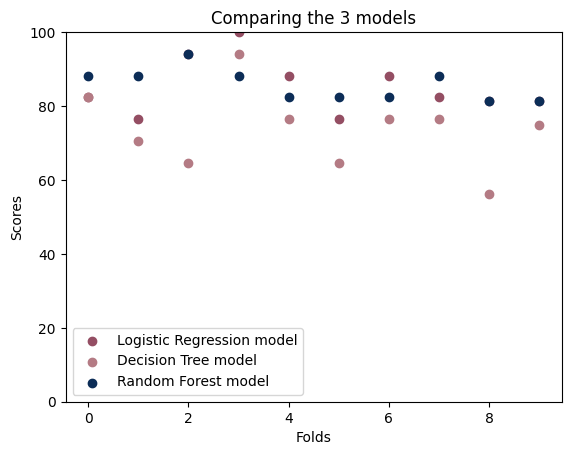

In [28]:
plt.scatter(
    indices,
    -linear_scores,
    color="#944E63",
    label="Logistic Regression model"
)

plt.scatter(
    indices,
    -tree_scores,
    color="#B47B84",
    label="Decision Tree model"
)

plt.scatter(
    indices,
    -ensemble_scores,
    color="#0C2D57",
    label="Random Forest model"
)

plt.ylim((0,100))
plt.legend()
plt.xlabel("Folds")
plt.ylabel("Scores")
_ = plt.title("Comparing the 3 models")

#### 4.2.4 - Conclusion 

In [29]:
model_scores = {
    "Logistic Regression": -linear_scores.mean(),
    "Decision Tree Model": -tree_scores.mean(),
    "Random Forest": -ensemble_scores.mean()
}

In [30]:
highest_score = max(model_scores.values())

In [31]:
best_models = [model for model, score in model_scores.items() if score == highest_score]

In [32]:
if len(best_models) == 1:
    print(f"The model with the highest accuracy score ({highest_score:.2f}%) is: {best_models[0]}")
else:
    print(f"Models with the highest accuracy score ({highest_score:.2f}%) are:")
    for model in best_models:
        print(f"\t- {model}")

The model with the highest accuracy score (85.66%) is: Random Forest


## 5 - Exporting best model in AWS S3

In [33]:
prefix = "models/"
filename_model = "piq_model.pkl"

In [34]:
ensemble_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [35]:
try:
    os.makedirs(prefix, exist_ok=True)
    joblib.dump(ensemble_pipeline, prefix+filename_model)
    print(f"Successfully saved the best model ({best_models[0]}) as {filename_model}.")
except Exception as e:
    print(f"Error saving the model: {e}")

Successfully saved the best model (Random Forest) as piq_model.pkl.


In [36]:
s3.upload_file(prefix + filename_model, bucket_name, prefix + filename_model)

In [37]:
os.chdir(prefix)
os.remove(filename_model)
print("models : ")
print("- - - " * 3)
if len(os.listdir()) > 1:
        for file in os.listdir():
            print(file)
else: 
    print("You'll retreive all models in AWS S3 !")
os.chdir("../")

models : 
- - - - - - - - - 
You'll retreive all models in AWS S3 !
